# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

In [1]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_5.h5'
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
validation_split = .1
use_skeleton = False

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%load_ext autoreload
%autoreload 2

data_generator = DataGenerator(dataset, zeros_to_nan=True)

## view sample frame

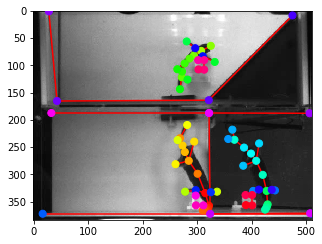

106
total frames: 82


In [3]:
frame_num = np.random.choice(len(data_generator))

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)
print('total frames:', len(data_generator))

## set up image augmentation

In [4]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

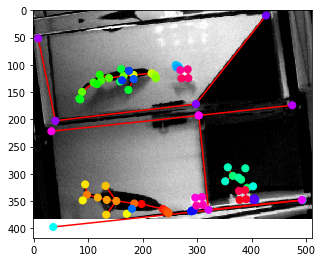

In [5]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [6]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=.1, 
                                    use_graph=use_skeleton,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 74,
 'n_validation': 8,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_5.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 82,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# check `TrainingGenerator` output

D:\anaconda3\envs\dpk\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


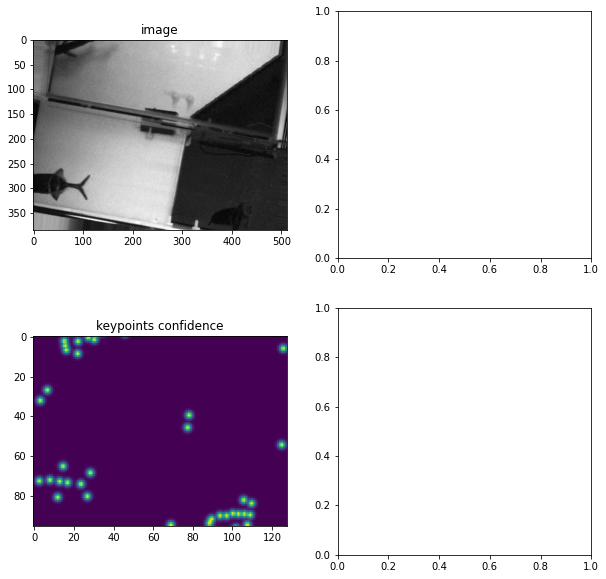

In [7]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

if use_skeleton:
    ax2.set_title('posture graph')
    ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

if use_skeleton:
    ax4.set_title('posture graph and keypoints confidence')
    ax4.imshow(outputs[0,...,-1], vmin=0)

plt.show()
train_generator.on_epoch_end()

# define a model

In [8]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 74,
 'n_validation': 8,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_5.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 82,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [9]:
# batch_size = 32
# data_size = (10000,) + data_generator.image_shape
# x = np.random.randint(0, 255, data_size, dtype="uint8")
# y = model.predict(x[:256], batch_size=batch_size)  # make sure the model is in GPU memory
# t0 = time.time()
# y = model.predict(x, batch_size=32, verbose=1)
# t1 = time.time()
# print(x.shape[0] / (t1 - t0))

# define training callbacks

In [10]:
logger = Logger(validation_batch_size=2,  # make sure this isn't too big!
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/800
8/9 [=========================>....] - ETA: 1s - loss: 42.3434 - output_0_loss: 13.9544 - output_1_loss: 14.2101 - output_2_loss: 14.1788evaluation_metrics: 
euclidean - mean: 53620.11 (0%:  1.09, 5%: 13.16, 25%: 155.24, 50%: 312.30, 75%: 141741.24, 95%: 141928.72, 100%: 142047.26) 
confidence - mean:  0.00 (0%:  0.00, 5%:  0.00, 25%:  0.00, 50%:  0.00, 75%:  0.00, 95%:  0.01, 100%:  0.01) 


Epoch 00001: val_loss improved from inf to 48.04915, saving model to D:\github\fish-tracking\train\models\tank_model.h5
9/9 [==============================] - 15s 2s/step - loss: 41.8069 - output_0_loss: 13.7999 - output_1_loss: 14.0187 - output_2_loss: 13.9883 - val_loss: 48.0491 - val_output_0_loss: 16.0035 - val_output_1_loss: 16.0075 - val_output_2_loss: 16.0381
Epoch 2/800
8/9 [=========================>....] - ETA: 0s - loss: 41.0899 - output_0_loss: 13.8047 - output_1_loss: 13.6738 - output_2_loss: 13.6114evaluation_metrics: 
euclidean - mean: 53619.62 (0%:  0.59, 5%:  8.01, 25%

Epoch 12/800
8/9 [=========================>....] - ETA: 0s - loss: 32.5980 - output_0_loss: 12.4403 - output_1_loss: 10.4273 - output_2_loss: 9.7303evaluation_metrics: 
euclidean - mean: 53552.51 (0%:  0.07, 5%:  1.17, 25%: 17.53, 50%: 198.13, 75%: 141699.34, 95%: 141945.64, 100%: 141972.91) 
confidence - mean:  0.02 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.03, 95%:  0.08, 100%:  0.21) 


Epoch 00012: val_loss improved from 47.07300 to 46.59198, saving model to D:\github\fish-tracking\train\models\tank_model.h5
9/9 [==============================] - 8s 922ms/step - loss: 32.4273 - output_0_loss: 12.3829 - output_1_loss: 10.3740 - output_2_loss: 9.6705 - val_loss: 46.5920 - val_output_0_loss: 15.7416 - val_output_1_loss: 15.4557 - val_output_2_loss: 15.3947
Epoch 13/800
8/9 [=========================>....] - ETA: 0s - loss: 32.0613 - output_0_loss: 12.3126 - output_1_loss: 10.2367 - output_2_loss: 9.5120evaluation_metrics: 
euclidean - mean: 53551.01 (0%:  0.28, 5%:  1.62

Epoch 23/800
8/9 [=========================>....] - ETA: 0s - loss: 26.7134 - output_0_loss: 10.8779 - output_1_loss: 8.2551 - output_2_loss: 7.5804evaluation_metrics: 
euclidean - mean: 53558.82 (0%:  0.16, 5%:  1.07, 25%:  3.78, 50%: 157.60, 75%: 141784.69, 95%: 141948.06, 100%: 141965.83) 
confidence - mean:  0.09 (0%:  0.00, 5%:  0.01, 25%:  0.01, 50%:  0.03, 75%:  0.12, 95%:  0.36, 100%:  0.54) 


Epoch 00023: val_loss did not improve from 39.46719
9/9 [==============================] - 8s 875ms/step - loss: 26.6269 - output_0_loss: 10.8886 - output_1_loss: 8.2099 - output_2_loss: 7.5283 - val_loss: 40.9126 - val_output_0_loss: 14.8269 - val_output_1_loss: 13.2960 - val_output_2_loss: 12.7898
Epoch 24/800
8/9 [=========================>....] - ETA: 0s - loss: 26.3833 - output_0_loss: 10.9130 - output_1_loss: 8.0990 - output_2_loss: 7.3713evaluation_metrics: 
euclidean - mean: 53535.12 (0%:  0.13, 5%:  0.94, 25%:  3.31, 50%: 76.02, 75%: 141726.31, 95%: 141948.07, 100%: 141959.15) 


Epoch 35/800
8/9 [=========================>....] - ETA: 0s - loss: 23.4816 - output_0_loss: 10.2699 - output_1_loss: 7.0142 - output_2_loss: 6.1974evaluation_metrics: 
euclidean - mean: 53545.90 (0%:  0.18, 5%:  0.92, 25%:  2.68, 50%: 58.24, 75%: 141804.00, 95%: 141949.33, 100%: 141969.86) 
confidence - mean:  0.14 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.06, 75%:  0.20, 95%:  0.53, 100%:  0.74) 


Epoch 00035: val_loss did not improve from 37.54412
9/9 [==============================] - 8s 872ms/step - loss: 23.5483 - output_0_loss: 10.3077 - output_1_loss: 7.0273 - output_2_loss: 6.2133 - val_loss: 38.4432 - val_output_0_loss: 14.6674 - val_output_1_loss: 12.3241 - val_output_2_loss: 11.4517
Epoch 36/800
8/9 [=========================>....] - ETA: 0s - loss: 23.2136 - output_0_loss: 10.2855 - output_1_loss: 6.8831 - output_2_loss: 6.0450evaluation_metrics: 
euclidean - mean: 53547.44 (0%:  0.14, 5%:  0.86, 25%:  2.90, 50%: 97.03, 75%: 141739.29, 95%: 141946.44, 100%: 141952.57) 
c

8/9 [=========================>....] - ETA: 0s - loss: 21.4704 - output_0_loss: 9.8164 - output_1_loss: 6.2596 - output_2_loss: 5.3944evaluation_metrics: 
euclidean - mean: 53537.67 (0%:  0.19, 5%:  0.72, 25%:  2.09, 50%: 50.66, 75%: 141760.33, 95%: 141949.83, 100%: 141971.75) 
confidence - mean:  0.25 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.08, 75%:  0.52, 95%:  0.76, 100%:  0.88) 


Epoch 00046: val_loss did not improve from 29.01399
9/9 [==============================] - 8s 875ms/step - loss: 21.7113 - output_0_loss: 9.9329 - output_1_loss: 6.3265 - output_2_loss: 5.4519 - val_loss: 30.8938 - val_output_0_loss: 12.7196 - val_output_1_loss: 9.5620 - val_output_2_loss: 8.6122
Epoch 47/800
8/9 [=========================>....] - ETA: 0s - loss: 21.0881 - output_0_loss: 9.5788 - output_1_loss: 6.1863 - output_2_loss: 5.3231evaluation_metrics: 
euclidean - mean: 53541.17 (0%:  0.06, 5%:  0.68, 25%:  2.17, 50%: 48.27, 75%: 141784.51, 95%: 141949.12, 100%: 141999.54) 
confidence - mean: 

Epoch 58/800
8/9 [=========================>....] - ETA: 0s - loss: 20.5055 - output_0_loss: 9.5725 - output_1_loss: 5.8855 - output_2_loss: 5.0474evaluation_metrics: 
euclidean - mean: 53543.66 (0%:  0.15, 5%:  0.74, 25%:  2.19, 50%: 55.34, 75%: 141786.64, 95%: 141950.00, 100%: 141998.55) 
confidence - mean:  0.25 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.08, 75%:  0.48, 95%:  0.80, 100%:  1.02) 


Epoch 00058: val_loss did not improve from 29.01399
9/9 [==============================] - 8s 870ms/step - loss: 20.6402 - output_0_loss: 9.6484 - output_1_loss: 5.9261 - output_2_loss: 5.0656 - val_loss: 30.8016 - val_output_0_loss: 12.3409 - val_output_1_loss: 9.5765 - val_output_2_loss: 8.8842
Epoch 59/800
8/9 [=========================>....] - ETA: 0s - loss: 19.2474 - output_0_loss: 9.0826 - output_1_loss: 5.4980 - output_2_loss: 4.6668evaluation_metrics: 
euclidean - mean: 53540.40 (0%:  0.12, 5%:  0.72, 25%:  1.91, 50%: 34.79, 75%: 141784.86, 95%: 141949.33, 100%: 141998.22) 
confid

8/9 [=========================>....] - ETA: 0s - loss: 17.5887 - output_0_loss: 8.6753 - output_1_loss: 4.9026 - output_2_loss: 4.0108evaluation_metrics: 
euclidean - mean: 53531.95 (0%:  0.04, 5%:  0.44, 25%:  1.51, 50%:  7.75, 75%: 141807.79, 95%: 141952.70, 100%: 142002.26) 
confidence - mean:  0.37 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.23, 75%:  0.74, 95%:  0.91, 100%:  1.02) 


Epoch 00069: val_loss improved from 24.19778 to 24.02750, saving model to D:\github\fish-tracking\train\models\tank_model.h5
9/9 [==============================] - 8s 922ms/step - loss: 17.5381 - output_0_loss: 8.6552 - output_1_loss: 4.8880 - output_2_loss: 3.9949 - val_loss: 24.0275 - val_output_0_loss: 10.8213 - val_output_1_loss: 6.9968 - val_output_2_loss: 6.2094
Epoch 70/800
8/9 [=========================>....] - ETA: 0s - loss: 17.5958 - output_0_loss: 8.7187 - output_1_loss: 4.8830 - output_2_loss: 3.9941evaluation_metrics: 
euclidean - mean: 53536.39 (0%:  0.04, 5%:  0.43, 25%:  1.48, 50%:  7.

Epoch 80/800
8/9 [=========================>....] - ETA: 0s - loss: 18.1538 - output_0_loss: 8.9637 - output_1_loss: 5.0737 - output_2_loss: 4.1164evaluation_metrics: 
euclidean - mean: 53536.30 (0%:  0.03, 5%:  0.43, 25%:  1.49, 50%:  7.04, 75%: 141821.94, 95%: 141951.72, 100%: 142002.89) 
confidence - mean:  0.39 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.27, 75%:  0.79, 95%:  0.90, 100%:  1.01) 


Epoch 00080: val_loss did not improve from 22.70282
9/9 [==============================] - 8s 883ms/step - loss: 18.0200 - output_0_loss: 8.8922 - output_1_loss: 5.0366 - output_2_loss: 4.0912 - val_loss: 22.8504 - val_output_0_loss: 10.4386 - val_output_1_loss: 6.5704 - val_output_2_loss: 5.8414
Epoch 81/800
8/9 [=========================>....] - ETA: 0s - loss: 18.3473 - output_0_loss: 9.1186 - output_1_loss: 5.1210 - output_2_loss: 4.1077evaluation_metrics: 
euclidean - mean: 53537.08 (0%:  0.00, 5%:  0.45, 25%:  1.46, 50%:  6.87, 75%: 141821.30, 95%: 141960.51, 100%: 142034.60) 
confid

Epoch 92/800
8/9 [=========================>....] - ETA: 0s - loss: 17.2140 - output_0_loss: 8.7512 - output_1_loss: 4.7471 - output_2_loss: 3.7157evaluation_metrics: 
euclidean - mean: 53536.53 (0%:  0.06, 5%:  0.39, 25%:  1.44, 50%:  6.55, 75%: 141817.67, 95%: 141958.74, 100%: 142033.24) 
confidence - mean:  0.41 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.32, 75%:  0.82, 95%:  0.93, 100%:  1.02) 


Epoch 00092: val_loss improved from 22.30947 to 22.26207, saving model to D:\github\fish-tracking\train\models\tank_model.h5
9/9 [==============================] - 8s 922ms/step - loss: 17.0717 - output_0_loss: 8.6375 - output_1_loss: 4.7215 - output_2_loss: 3.7127 - val_loss: 22.2621 - val_output_0_loss: 10.1308 - val_output_1_loss: 6.4038 - val_output_2_loss: 5.7274
Epoch 93/800
8/9 [=========================>....] - ETA: 0s - loss: 17.2998 - output_0_loss: 8.6667 - output_1_loss: 4.8034 - output_2_loss: 3.8297evaluation_metrics: 
euclidean - mean: 53533.79 (0%:  0.04, 5%:  0.37, 25%:  1

Epoch 104/800
8/9 [=========================>....] - ETA: 0s - loss: 17.6292 - output_0_loss: 8.9098 - output_1_loss: 4.8872 - output_2_loss: 3.8322evaluation_metrics: 
euclidean - mean: 53531.80 (0%:  0.06, 5%:  0.41, 25%:  1.46, 50%:  6.88, 75%: 141812.71, 95%: 141957.33, 100%: 142005.83) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.33, 75%:  0.82, 95%:  0.95, 100%:  1.07) 


Epoch 00104: val_loss did not improve from 22.01963
9/9 [==============================] - 8s 875ms/step - loss: 17.3973 - output_0_loss: 8.7843 - output_1_loss: 4.8316 - output_2_loss: 3.7814 - val_loss: 22.2636 - val_output_0_loss: 10.0651 - val_output_1_loss: 6.4031 - val_output_2_loss: 5.7954
Epoch 105/800
8/9 [=========================>....] - ETA: 0s - loss: 17.2208 - output_0_loss: 8.7382 - output_1_loss: 4.7528 - output_2_loss: 3.7298evaluation_metrics: 
euclidean - mean: 53533.17 (0%:  0.06, 5%:  0.36, 25%:  1.45, 50%:  6.79, 75%: 141815.05, 95%: 141961.29, 100%: 142005.75) 
conf

Epoch 116/800
8/9 [=========================>....] - ETA: 0s - loss: 16.2934 - output_0_loss: 8.3420 - output_1_loss: 4.4810 - output_2_loss: 3.4705evaluation_metrics: 
euclidean - mean: 53530.12 (0%:  0.02, 5%:  0.45, 25%:  1.41, 50%:  6.35, 75%: 141799.31, 95%: 141960.17, 100%: 142034.99) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.35, 75%:  0.83, 95%:  0.95, 100%:  1.07) 


Epoch 00116: val_loss did not improve from 22.01963
9/9 [==============================] - 8s 879ms/step - loss: 16.3375 - output_0_loss: 8.3701 - output_1_loss: 4.4929 - output_2_loss: 3.4745 - val_loss: 22.1150 - val_output_0_loss: 10.0544 - val_output_1_loss: 6.3770 - val_output_2_loss: 5.6837
Epoch 117/800
8/9 [=========================>....] - ETA: 0s - loss: 16.9941 - output_0_loss: 8.5940 - output_1_loss: 4.7154 - output_2_loss: 3.6846evaluation_metrics: 
euclidean - mean: 53533.20 (0%:  0.06, 5%:  0.41, 25%:  1.42, 50%:  6.19, 75%: 141812.70, 95%: 141958.45, 100%: 142030.69) 
conf

8/9 [=========================>....] - ETA: 0s - loss: 15.3724 - output_0_loss: 7.9899 - output_1_loss: 4.1956 - output_2_loss: 3.1869evaluation_metrics: 
euclidean - mean: 53534.73 (0%:  0.05, 5%:  0.38, 25%:  1.42, 50%:  6.08, 75%: 141817.98, 95%: 141962.17, 100%: 142032.93) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.33, 75%:  0.82, 95%:  0.93, 100%:  1.05) 


Epoch 00127: val_loss did not improve from 21.68568
9/9 [==============================] - 8s 874ms/step - loss: 15.4080 - output_0_loss: 7.9988 - output_1_loss: 4.2007 - output_2_loss: 3.2085 - val_loss: 21.7006 - val_output_0_loss: 9.9202 - val_output_1_loss: 6.2233 - val_output_2_loss: 5.5571
Epoch 128/800
8/9 [=========================>....] - ETA: 0s - loss: 16.6048 - output_0_loss: 8.5859 - output_1_loss: 4.5541 - output_2_loss: 3.4648evaluation_metrics: 
euclidean - mean: 53532.83 (0%:  0.02, 5%:  0.38, 25%:  1.45, 50%:  5.90, 75%: 141817.24, 95%: 141961.56, 100%: 142032.59) 
confidence - mean: 

Epoch 139/800
8/9 [=========================>....] - ETA: 0s - loss: 15.7512 - output_0_loss: 8.1654 - output_1_loss: 4.3224 - output_2_loss: 3.2634evaluation_metrics: 
euclidean - mean: 53536.76 (0%:  0.02, 5%:  0.38, 25%:  1.45, 50%:  5.90, 75%: 141828.67, 95%: 141961.97, 100%: 142032.70) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.37, 75%:  0.83, 95%:  0.94, 100%:  1.06) 


Epoch 00139: val_loss did not improve from 21.61645
9/9 [==============================] - 8s 872ms/step - loss: 16.0839 - output_0_loss: 8.3616 - output_1_loss: 4.4136 - output_2_loss: 3.3088 - val_loss: 21.6362 - val_output_0_loss: 9.8930 - val_output_1_loss: 6.2009 - val_output_2_loss: 5.5422
Epoch 140/800
8/9 [=========================>....] - ETA: 0s - loss: 16.1507 - output_0_loss: 8.5181 - output_1_loss: 4.3764 - output_2_loss: 3.2561evaluation_metrics: 
euclidean - mean: 53534.29 (0%:  0.05, 5%:  0.37, 25%:  1.45, 50%:  5.88, 75%: 141821.90, 95%: 141961.89, 100%: 142035.50) 
confi

Epoch 151/800
8/9 [=========================>....] - ETA: 0s - loss: 15.9874 - output_0_loss: 8.4211 - output_1_loss: 4.3423 - output_2_loss: 3.2239evaluation_metrics: 
euclidean - mean: 53536.86 (0%:  0.08, 5%:  0.36, 25%:  1.44, 50%:  5.86, 75%: 141824.92, 95%: 141962.47, 100%: 142035.05) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.37, 75%:  0.83, 95%:  0.94, 100%:  1.08) 


Epoch 00151: val_loss did not improve from 21.50920
9/9 [==============================] - 8s 875ms/step - loss: 15.9683 - output_0_loss: 8.4037 - output_1_loss: 4.3317 - output_2_loss: 3.2329 - val_loss: 21.7699 - val_output_0_loss: 9.8512 - val_output_1_loss: 6.2525 - val_output_2_loss: 5.6662
Epoch 152/800
8/9 [=========================>....] - ETA: 0s - loss: 16.1816 - output_0_loss: 8.4509 - output_1_loss: 4.4182 - output_2_loss: 3.3125evaluation_metrics: 
euclidean - mean: 53534.85 (0%:  0.03, 5%:  0.36, 25%:  1.44, 50%:  5.81, 75%: 141821.51, 95%: 141962.03, 100%: 142035.44) 
confi

Epoch 163/800
8/9 [=========================>....] - ETA: 0s - loss: 16.5711 - output_0_loss: 8.6254 - output_1_loss: 4.5424 - output_2_loss: 3.4033evaluation_metrics: 
euclidean - mean: 53535.97 (0%:  0.00, 5%:  0.36, 25%:  1.38, 50%:  5.68, 75%: 141825.56, 95%: 141960.20, 100%: 142032.79) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.37, 75%:  0.84, 95%:  0.95, 100%:  1.08) 


Epoch 00163: val_loss did not improve from 21.50920
9/9 [==============================] - 8s 858ms/step - loss: 16.3712 - output_0_loss: 8.5378 - output_1_loss: 4.4732 - output_2_loss: 3.3601 - val_loss: 21.5185 - val_output_0_loss: 9.8118 - val_output_1_loss: 6.1740 - val_output_2_loss: 5.5327
Epoch 164/800
8/9 [=========================>....] - ETA: 0s - loss: 16.0896 - output_0_loss: 8.4507 - output_1_loss: 4.3751 - output_2_loss: 3.2638evaluation_metrics: 
euclidean - mean: 53533.79 (0%:  0.06, 5%:  0.38, 25%:  1.40, 50%:  5.54, 75%: 141821.64, 95%: 141959.92, 100%: 142032.90) 
confi

8/9 [=========================>....] - ETA: 0s - loss: 15.7676 - output_0_loss: 8.2645 - output_1_loss: 4.2986 - output_2_loss: 3.2045evaluation_metrics: 
euclidean - mean: 53537.63 (0%:  0.04, 5%:  0.37, 25%:  1.42, 50%:  5.61, 75%: 141839.00, 95%: 141961.41, 100%: 142034.06) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.83, 95%:  0.95, 100%:  1.06) 


Epoch 00174: val_loss did not improve from 21.44058
9/9 [==============================] - 8s 872ms/step - loss: 15.6739 - output_0_loss: 8.2509 - output_1_loss: 4.2628 - output_2_loss: 3.1603 - val_loss: 21.4958 - val_output_0_loss: 9.7975 - val_output_1_loss: 6.1665 - val_output_2_loss: 5.5319
Epoch 175/800
8/9 [=========================>....] - ETA: 0s - loss: 16.7611 - output_0_loss: 8.6153 - output_1_loss: 4.6194 - output_2_loss: 3.5263evaluation_metrics: 
euclidean - mean: 53537.54 (0%:  0.04, 5%:  0.38, 25%:  1.43, 50%:  5.56, 75%: 141842.74, 95%: 141960.71, 100%: 142034.09) 
confidence - mean: 

Epoch 186/800
8/9 [=========================>....] - ETA: 0s - loss: 16.6885 - output_0_loss: 8.7126 - output_1_loss: 4.5601 - output_2_loss: 3.4159evaluation_metrics: 
euclidean - mean: 53536.98 (0%:  0.08, 5%:  0.37, 25%:  1.42, 50%:  5.58, 75%: 141833.26, 95%: 141960.51, 100%: 142034.17) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.37, 75%:  0.83, 95%:  0.95, 100%:  1.06) 


Epoch 00186: val_loss did not improve from 21.43487
9/9 [==============================] - 8s 863ms/step - loss: 16.6502 - output_0_loss: 8.6981 - output_1_loss: 4.5418 - output_2_loss: 3.4103 - val_loss: 21.4755 - val_output_0_loss: 9.8015 - val_output_1_loss: 6.1591 - val_output_2_loss: 5.5148
Epoch 187/800
8/9 [=========================>....] - ETA: 0s - loss: 16.0333 - output_0_loss: 8.3486 - output_1_loss: 4.4040 - output_2_loss: 3.2807evaluation_metrics: 
euclidean - mean: 53536.82 (0%:  0.08, 5%:  0.37, 25%:  1.44, 50%:  5.58, 75%: 141837.55, 95%: 141960.10, 100%: 142032.87) 
confi

Epoch 198/800
8/9 [=========================>....] - ETA: 0s - loss: 15.6504 - output_0_loss: 8.2267 - output_1_loss: 4.2521 - output_2_loss: 3.1716evaluation_metrics: 
euclidean - mean: 53537.65 (0%:  0.02, 5%:  0.37, 25%:  1.44, 50%:  5.47, 75%: 141837.13, 95%: 141961.08, 100%: 142034.26) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.83, 95%:  0.95, 100%:  1.07) 


Epoch 00198: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 876ms/step - loss: 15.8656 - output_0_loss: 8.2826 - output_1_loss: 4.3291 - output_2_loss: 3.2538 - val_loss: 21.4091 - val_output_0_loss: 9.7874 - val_output_1_loss: 6.1386 - val_output_2_loss: 5.4831
Epoch 199/800
8/9 [=========================>....] - ETA: 0s - loss: 15.4705 - output_0_loss: 8.1379 - output_1_loss: 4.1861 - output_2_loss: 3.1466evaluation_metrics: 
euclidean - mean: 53537.62 (0%:  0.04, 5%:  0.37, 25%:  1.44, 50%:  5.53, 75%: 141837.14, 95%: 141960.88, 100%: 142034.26) 
confi

Epoch 210/800
8/9 [=========================>....] - ETA: 0s - loss: 15.7550 - output_0_loss: 8.3085 - output_1_loss: 4.2978 - output_2_loss: 3.1487evaluation_metrics: 
euclidean - mean: 53537.93 (0%:  0.04, 5%:  0.37, 25%:  1.45, 50%:  5.59, 75%: 141840.79, 95%: 141960.89, 100%: 142034.62) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.37, 75%:  0.84, 95%:  0.95, 100%:  1.06) 


Epoch 00210: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 861ms/step - loss: 15.8953 - output_0_loss: 8.4171 - output_1_loss: 4.3190 - output_2_loss: 3.1592 - val_loss: 21.4164 - val_output_0_loss: 9.7867 - val_output_1_loss: 6.1408 - val_output_2_loss: 5.4889
Epoch 211/800
8/9 [=========================>....] - ETA: 0s - loss: 16.2431 - output_0_loss: 8.5481 - output_1_loss: 4.4208 - output_2_loss: 3.2743evaluation_metrics: 
euclidean - mean: 53537.56 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.58, 75%: 141837.52, 95%: 141961.24, 100%: 142034.62) 
confi

Epoch 222/800
8/9 [=========================>....] - ETA: 0s - loss: 15.2986 - output_0_loss: 8.1258 - output_1_loss: 4.1279 - output_2_loss: 3.0449evaluation_metrics: 
euclidean - mean: 53537.19 (0%:  0.04, 5%:  0.38, 25%:  1.45, 50%:  5.66, 75%: 141831.69, 95%: 141961.16, 100%: 142034.48) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.84, 95%:  0.95, 100%:  1.06) 


Epoch 00222: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 872ms/step - loss: 15.3472 - output_0_loss: 8.1383 - output_1_loss: 4.1496 - output_2_loss: 3.0593 - val_loss: 21.4463 - val_output_0_loss: 9.7823 - val_output_1_loss: 6.1508 - val_output_2_loss: 5.5132
Epoch 223/800
8/9 [=========================>....] - ETA: 0s - loss: 15.9399 - output_0_loss: 8.2632 - output_1_loss: 4.3694 - output_2_loss: 3.3074evaluation_metrics: 
euclidean - mean: 53537.15 (0%:  0.04, 5%:  0.37, 25%:  1.45, 50%:  5.67, 75%: 141833.22, 95%: 141961.05, 100%: 142034.51) 
confi

Epoch 234/800
8/9 [=========================>....] - ETA: 0s - loss: 15.7405 - output_0_loss: 8.3112 - output_1_loss: 4.2797 - output_2_loss: 3.1496evaluation_metrics: 
euclidean - mean: 53536.91 (0%:  0.04, 5%:  0.37, 25%:  1.44, 50%:  5.64, 75%: 141833.27, 95%: 141960.21, 100%: 142034.45) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.84, 95%:  0.95, 100%:  1.06) 


Epoch 00234: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 868ms/step - loss: 15.9668 - output_0_loss: 8.4104 - output_1_loss: 4.3470 - output_2_loss: 3.2093 - val_loss: 21.4314 - val_output_0_loss: 9.7762 - val_output_1_loss: 6.1482 - val_output_2_loss: 5.5071
Epoch 235/800
8/9 [=========================>....] - ETA: 0s - loss: 15.7023 - output_0_loss: 8.2491 - output_1_loss: 4.2705 - output_2_loss: 3.1828evaluation_metrics: 
euclidean - mean: 53536.90 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.67, 75%: 141833.26, 95%: 141960.19, 100%: 142034.45) 
confi

Epoch 246/800
8/9 [=========================>....] - ETA: 0s - loss: 15.8456 - output_0_loss: 8.2758 - output_1_loss: 4.3191 - output_2_loss: 3.2507evaluation_metrics: 
euclidean - mean: 53537.41 (0%:  0.06, 5%:  0.37, 25%:  1.46, 50%:  5.61, 75%: 141842.63, 95%: 141960.26, 100%: 142034.43) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.83, 95%:  0.95, 100%:  1.06) 


Epoch 00246: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 860ms/step - loss: 15.9414 - output_0_loss: 8.3422 - output_1_loss: 4.3435 - output_2_loss: 3.2557 - val_loss: 21.4325 - val_output_0_loss: 9.7755 - val_output_1_loss: 6.1494 - val_output_2_loss: 5.5076
Epoch 247/800
8/9 [=========================>....] - ETA: 0s - loss: 15.9321 - output_0_loss: 8.3795 - output_1_loss: 4.3311 - output_2_loss: 3.2215evaluation_metrics: 
euclidean - mean: 53537.19 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.63, 75%: 141842.62, 95%: 141960.31, 100%: 142034.43) 
confi

Epoch 258/800
8/9 [=========================>....] - ETA: 0s - loss: 15.4844 - output_0_loss: 8.1448 - output_1_loss: 4.2228 - output_2_loss: 3.1169evaluation_metrics: 
euclidean - mean: 53536.57 (0%:  0.04, 5%:  0.37, 25%:  1.45, 50%:  5.63, 75%: 141833.26, 95%: 141960.31, 100%: 142034.40) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.84, 95%:  0.95, 100%:  1.07) 


Epoch 00258: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 881ms/step - loss: 15.7246 - output_0_loss: 8.2900 - output_1_loss: 4.2835 - output_2_loss: 3.1511 - val_loss: 21.4303 - val_output_0_loss: 9.7748 - val_output_1_loss: 6.1476 - val_output_2_loss: 5.5079
Epoch 259/800
8/9 [=========================>....] - ETA: 0s - loss: 15.7879 - output_0_loss: 8.2179 - output_1_loss: 4.3106 - output_2_loss: 3.2593evaluation_metrics: 
euclidean - mean: 53536.68 (0%:  0.06, 5%:  0.37, 25%:  1.45, 50%:  5.64, 75%: 141833.26, 95%: 141960.36, 100%: 142034.40) 
confi

Epoch 270/800
8/9 [=========================>....] - ETA: 0s - loss: 15.6998 - output_0_loss: 8.2785 - output_1_loss: 4.2687 - output_2_loss: 3.1526evaluation_metrics: 
euclidean - mean: 53536.61 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.61, 75%: 141837.16, 95%: 141960.26, 100%: 142034.43) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.83, 95%:  0.95, 100%:  1.07) 


Epoch 00270: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 877ms/step - loss: 15.7065 - output_0_loss: 8.2883 - output_1_loss: 4.2682 - output_2_loss: 3.1501 - val_loss: 21.4330 - val_output_0_loss: 9.7762 - val_output_1_loss: 6.1485 - val_output_2_loss: 5.5083
Epoch 271/800
8/9 [=========================>....] - ETA: 0s - loss: 16.0632 - output_0_loss: 8.4294 - output_1_loss: 4.3876 - output_2_loss: 3.2462evaluation_metrics: 
euclidean - mean: 53536.42 (0%:  0.00, 5%:  0.37, 25%:  1.45, 50%:  5.61, 75%: 141833.26, 95%: 141960.26, 100%: 142034.43) 
confi

Epoch 282/800
8/9 [=========================>....] - ETA: 0s - loss: 16.2505 - output_0_loss: 8.4665 - output_1_loss: 4.4530 - output_2_loss: 3.3310evaluation_metrics: 
euclidean - mean: 53536.59 (0%:  0.04, 5%:  0.38, 25%:  1.46, 50%:  5.60, 75%: 141837.16, 95%: 141960.38, 100%: 142034.45) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.83, 95%:  0.96, 100%:  1.07) 


Epoch 00282: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 878ms/step - loss: 16.3824 - output_0_loss: 8.5040 - output_1_loss: 4.4896 - output_2_loss: 3.3887 - val_loss: 21.4367 - val_output_0_loss: 9.7769 - val_output_1_loss: 6.1499 - val_output_2_loss: 5.5099
Epoch 283/800
8/9 [=========================>....] - ETA: 0s - loss: 14.9370 - output_0_loss: 7.8819 - output_1_loss: 4.0555 - output_2_loss: 2.9997evaluation_metrics: 
euclidean - mean: 53536.80 (0%:  0.04, 5%:  0.38, 25%:  1.46, 50%:  5.62, 75%: 141838.99, 95%: 141960.38, 100%: 142034.43) 
confi

Epoch 294/800
8/9 [=========================>....] - ETA: 0s - loss: 16.2560 - output_0_loss: 8.6115 - output_1_loss: 4.4068 - output_2_loss: 3.2377evaluation_metrics: 
euclidean - mean: 53536.65 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.61, 75%: 141833.26, 95%: 141960.35, 100%: 142034.43) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.38, 75%:  0.84, 95%:  0.95, 100%:  1.07) 


Epoch 00294: val_loss did not improve from 21.39429
9/9 [==============================] - 8s 875ms/step - loss: 16.3372 - output_0_loss: 8.5712 - output_1_loss: 4.4516 - output_2_loss: 3.3144 - val_loss: 21.4331 - val_output_0_loss: 9.7779 - val_output_1_loss: 6.1480 - val_output_2_loss: 5.5072
Epoch 295/800
8/9 [=========================>....] - ETA: 0s - loss: 15.6250 - output_0_loss: 8.2396 - output_1_loss: 4.2352 - output_2_loss: 3.1503evaluation_metrics: 
euclidean - mean: 53536.86 (0%:  0.04, 5%:  0.37, 25%:  1.46, 50%:  5.62, 75%: 141837.16, 95%: 141960.33, 100%: 142034.43) 
confi

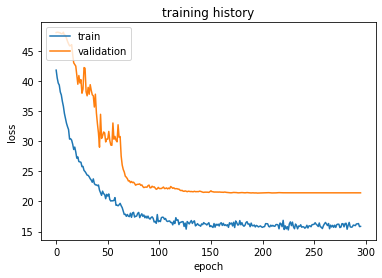

In [11]:
# train
history = model.fit(
    batch_size=8,             # adjust as training set expands
    validation_batch_size=2,  # adjust as training set expands
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,     # set to None for automatic determination
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');